# 1. Prepare the data

In [2]:
import os

In [2]:
os.getcwd()

'C:\\Users\\dell\\Desktop\\projects\\Smile_Detection'

In [3]:
data_path = os.path.join(os.getcwd(),"data")
data_path

'C:\\Users\\dell\\Desktop\\projects\\Smile_Detection\\data'

In [3]:
import glob

In [5]:
listImPaths = glob.glob(os.path.join(data_path,'*/*/*.jpg'))
len(listImPaths)

13165

We have 13165 images in our dataset

In [4]:
import numpy as np
import cv2
import random

In [13]:
randImage = random.sample(listImPaths,25)

In [8]:
for i in randImage:
    img = cv2.imread(i)
    cv2.imshow("img",img)
    cv2.waitKey()

cv2.destroyAllWindows()

In [4]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Smile Dataset')

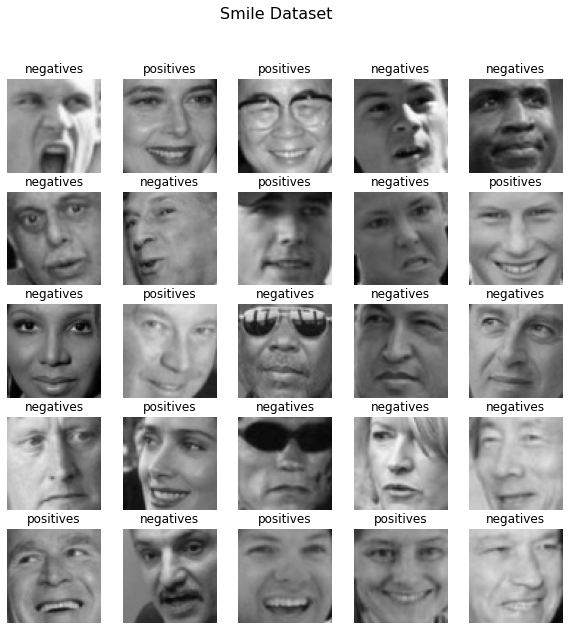

In [31]:
fig = plt.figure(figsize=(10, 10))
for i,j in enumerate(randImage):
    ax = plt.subplot(5, 5, i + 1)
    img = cv2.imread(j)
    plt.imshow(img)
    plt.title(j.split('\\')[-3])
    plt.axis("off")
fig.suptitle('Smile Dataset', fontsize=16)

Shuffle the data to improve the neural network's performance

In [32]:
random.shuffle(listImPaths)

In [6]:
import imutils
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

1. Load the SMILES dataset from disk and store it in memory
2. The image shape = (28,28,1)
3. Convert the image to an array compatible with Keras
4. Labels (0,1) : positives:1 // negatives:0
5. Image scalling 0,1
6. One hot encoding for the labels

In [35]:
data = []
labels = []
for pathIm in listImPaths:
    img = cv2.imread(pathIm)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = imutils.resize(img, width=28)
    img = img_to_array(img)
    data.append(img)
    label = pathIm.split('\\')[-3]
    if label == "positives":
        labels.append(1)
    else:
        labels.append(0)

data = np.array(data, dtype="float") /255.0
labels = np.array(labels)
labels = to_categorical(labels)

In [39]:
data.shape

(13165, 28, 28, 1)

To fight the data imbalance issue, we should apply same class weights

In [37]:
classTotal = labels.sum(axis=0)
classTotal

array([9475., 3690.], dtype=float32)

In this dataset, we have 9475 non smile images and only 3690 smile images

In [38]:
weight = dict()
for i in range(len(classTotal)):
    weight[i] = classTotal.max()/classTotal[i]

weight

{0: 1.0, 1: 2.5677507}

This weighting implies that our network will treat every instance of “smiling” as 2.567 instances of “not smiling”

Now that we’ve computed our class weights, we can move on to partitioning our data into training and testing splits, using 80% of the data for training and 20% for validation.

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=33)

# 2. Train the model

We're going to use to Lenet architecture

In [42]:
from utils import LeNet

In [43]:
SmileDetector = LeNet.build(width=28, height=28, depth=1, classes=2)

In [44]:
SmileDetector.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1225500   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [49]:
# construct the callback to save only the *best* model to disk
from tensorflow.keras.callbacks import ModelCheckpoint

In [50]:
filepath = os.path.sep.join([os.getcwd(),"sd_weights.hdf5"])

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='min',
                             save_best_only=True, verbose=1)

callbacks = [checkpoint]

In [47]:
SmileDetector.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [51]:
h = SmileDetector.fit(trainX, trainY, validation_data=(testX, testY), class_weight=weight, batch_size=64, epochs=15, callbacks=callbacks)

Epoch 1/15
164/165 [============================>.] - ETA: 0s - loss: 0.8284 - accuracy: 0.6646
Epoch 00001: val_loss improved from inf to 0.37494, saving model to C:\Users\dell\Desktop\projects\Smile_Detection\weights-001-0.3749.hdf5
165/165 [==============================] - 8s 47ms/step - loss: 0.8274 - accuracy: 0.6653 - val_loss: 0.3749 - val_accuracy: 0.8431
Epoch 2/15
164/165 [============================>.] - ETA: 0s - loss: 0.5096 - accuracy: 0.8477
Epoch 00002: val_loss improved from 0.37494 to 0.30648, saving model to C:\Users\dell\Desktop\projects\Smile_Detection\weights-002-0.3065.hdf5
165/165 [==============================] - 7s 42ms/step - loss: 0.5096 - accuracy: 0.8478 - val_loss: 0.3065 - val_accuracy: 0.8686
Epoch 3/15
165/165 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8683
Epoch 00003: val_loss improved from 0.30648 to 0.29377, saving model to C:\Users\dell\Desktop\projects\Smile_Detection\weights-003-0.2938.hdf5
165/165 [==============

# 3. Model performance

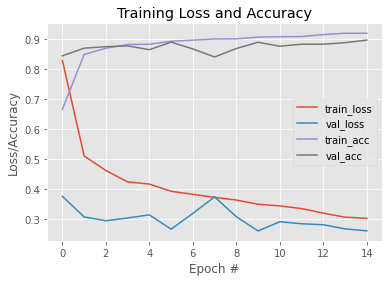

In [52]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 15), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# 4. Test

In [7]:
from tensorflow.keras.models import load_model

In [8]:
SD = load_model("sd_weights.hdf5")

To select the ROI, we'll use haarcascades from openCV

In [9]:
p = "C:\\Users\\dell\\Anaconda3\\envs\\DLprojects\\Library\\etc\\haarcascades"
classifier = cv2.CascadeClassifier(os.path.join(p,"haarcascade_frontalface_default.xml"))

In [24]:
vid = cv2.VideoCapture(0)
#vid = cv2.VideoCapture('testv1.mp4')
while(True):
    _, frame = vid.read()
    #print("1")
    frame = imutils.resize(frame, width=1000)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameClone = frame.copy()
    faces = classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    
    for x, y, w, h in faces:
        roi = gray[y:y + h, x:x + w]
        roi = cv2.resize(roi, (28, 28))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        (notSmiling, smiling) = SD.predict(roi)[0]
        if smiling > notSmiling:
            label = "Smiling"
            
        else:
            label = "Not Smiling"
        print(label)
        if label == "Smiling":
            
            cv2.putText(frameClone, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
            cv2.rectangle(frameClone, (x, y), (x + w, y + h),
                          (0, 255, 0), 2)
        else:
            cv2.putText(frameClone, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
            cv2.rectangle(frameClone, (x, y), (x + w, y + h),
                          (0, 0, 255), 2)
        
    cv2.imshow('frame', frameClone)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

Not Smiling
Not Smiling
Not Smiling
Not Smiling
Not Smiling
Smiling
Not Smiling
Not Smiling
Not Smiling
Not Smiling
Not Smiling
Not Smiling


In [11]:
vid.release()
cv2.destroyAllWindows()

Not Smiling
Smiling


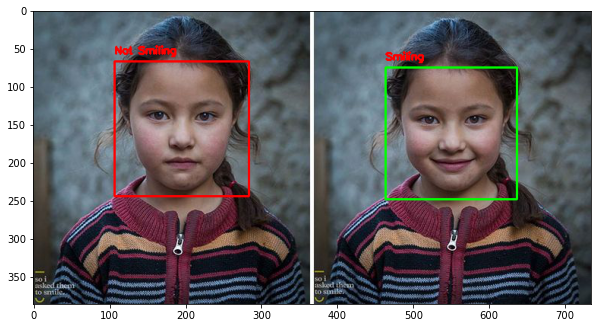

In [23]:
frame = cv2.imread("test.jpg")

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frameClone = frame.copy()
faces = classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

for x, y, w, h in faces:
    roi = gray[y:y + h, x:x + w]
    roi = cv2.resize(roi, (28, 28))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    (notSmiling, smiling) = SD.predict(roi)[0]
    if smiling > notSmiling:
        label = "Smiling"

    else:
        label = "Not Smiling"
    print(label)
    if label == "Smiling":

        cv2.putText(frameClone, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

        cv2.rectangle(frameClone, (x, y), (x + w, y + h),
                      (0, 255, 0), 2)
    else:
        cv2.putText(frameClone, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

        cv2.rectangle(frameClone, (x, y), (x + w, y + h),
                      (0, 0, 255), 2)

#cv2.imshow('frame', frameClone)
frameClone = cv2.cvtColor(frameClone, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(frameClone)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
